In [1]:
from imports import *
from tools import *

In [2]:
root_dir = '/Users/abarnes/Library/CloudStorage/Dropbox/Projects/Extragalactic/hstha_nebulae_catalogue/'
inputfile = '%s/all/nebulae_catalogue_wassociations_wprops_wpressures_fixediso_10pc.fits' %root_dir

table = QTable.read(inputfile)
print(f"Table length pre-masking: {len(table)}")

table = table[(table['flag_star_MUSE']!=1) & (table['flag_edge_MUSE']!=1) & (table["flag_edge_hst"]!=1)] # remove stars and edge objects

# remove regions with potential problems - manual checked
print(f'Table length pre manual-masking (inc. stars etc): {len(table)}')
print(f'Masked in manual check: {sum(~table['check'].mask)}')
table = table[table['check'].mask]

print(f'Table length post-masking (inc. stars etc): {len(table)}')

# mask hii regions 
mask_hiiregion = table['HII_class_v3_MUSE'] == True
table = table[mask_hiiregion]
print(f"Table length post-masking (HII regions): {len(table)}")

Table length pre-masking: 5467
Table length pre manual-masking (inc. stars etc): 5262
Masked in manual check: 85
Table length post-masking (inc. stars etc): 5177
Table length post-masking (HII regions): 4882


In [3]:
radius          = np.log10(table['mean_sigma_deconv_pc'].value)
radius_circ_pc  = np.log10(table['radius_circ_pc'].value)
radius_mom_pc   = np.log10(table['mean_sigma_pc'].value)
radius_strom_pc = np.log10(table['radius_strom_pc'].value)

radius_norm = table['mean_sigma_deconv_pc'].value/table['radius_strom_pc'].value

raduis_eff = table['r_reff_MUSE'].value

Pdir       = np.log10(table['Pdir_mom_deconv'].value)
Pdir_circ  = np.log10(table['Pdir_circ'].value)
Pdir_mom   = np.log10(table['Pdir_mom'].value)
Pdir_strom = np.log10(table['Pdir_strom'].value) 
Ptherm     = np.log10(table['Ptherm'].value)

# mass = np.log10(table['reg_dolflux_Mass_MinChiSq'].value)
# age = table['reg_dolflux_Age_MinChiSq'].value

# mass_ = np.log10(table['reg_dolflux_Mass_MinChiSq_sum'].value)
# age_ = table['reg_dolflux_Age_MinChiSq_massweighted'].value
# mass[~mass_.mask] = mass_[~mass_.mask]
# age[~age_.mask] = age_[~age_.mask]

sii = table['SII6716_FLUX_CORR_MUSE'].value
siii = table['SIII9068_FLUX_CORR_MUSE'].value
sii_err = table['SII6716_FLUX_CORR_ERR_MUSE'].value
siii_err = table['SIII9068_FLUX_CORR_ERR_MUSE'].value

s_mask = (sii > 0) & (siii > 0) & (siii/sii > 0) & (sii/sii_err>3) & (siii/siii_err>3)
ratio_siii_sii = np.log10(siii/sii)

ebv = table['EBV_MUSE'].value
lbol = table['Lbol'].value

table['met_scal_MUSE'].fill_value = np.nan
met = np.array(table['met_scal_MUSE'].value)

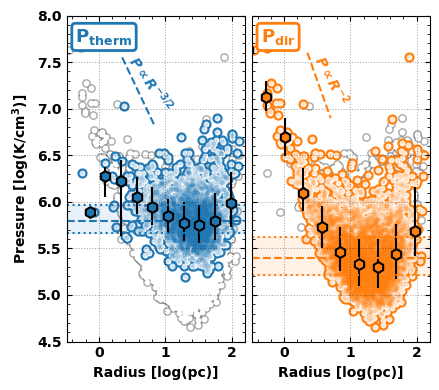

In [31]:
data_x1 = radius
data_y1 = Ptherm
data_x2 = radius
data_y2 = Pdir

fig = plt.figure(figsize=(4.5, 4)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, (ax, data_x, data_y) in enumerate(zip([ax1, ax2], [data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=40, c='C%i' %i, rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax.scatter(data_x, data_y, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i, linewidths=1.5)

    p1, med, p2 = np.percentile(data_y, [25, 50, 75])
    ax.axhline(med, color='C%i'%i, lw=1.5, ls='--')
    ax.axhline(p1, color='C%i'%i, lw=1.5, ls=':')
    ax.axhline(p2, color='C%i'%i, lw=1.5, ls=':')
    ax.fill_between([-1, 1e3], p1, p2, color='C%i'%i, alpha=0.1)


for i, (ax, data_x, data_y) in enumerate(zip([ax2, ax1], [data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=30, c='gray', rasterized=True, zorder=0, alpha=0.5)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True, zorder=0)

for ax in [ax1, ax2]: 

    ax.set_xlim(-0.49, 2.2)
    ax.set_ylim(4.5, 8)
    ax.set_xlabel('Radius [log(pc)]')
    ax.grid(True, alpha=0.35, ls=':', color='black')

# Add relations
x = np.array([1.8, 2.3])-1.5
ax1.plot(x+0.05, 8+(x*(-3/2)), color='C0', lw=1.5, ls='--')
x = np.array([1.95, 2.3])-1.6
ax2.plot(x, 8.3+(x*(-2)), color='C1', lw=1.5, ls='--')
ax1.text(0.4, 7.6, '$P \propto R^{-3/2}$', size=10, va='top', ha='left', color='C0', rotation=-55)
ax2.text(0.4, 7.6, '$P \propto R^{-2}$', size=10, va='top', ha='left', color='C1', rotation=-62)

ax1.set_ylabel('Pressure [log(K/cm$^3$)]')
ax2.set_yticklabels([])

ax1.text(0.05, 0.965, 'P$_\mathrm{therm}$', size=13, va='top', ha='left', weight='heavy', color='C0', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='C0', boxstyle='round,pad=0.2', linewidth=2))
ax2.text(0.05, 0.965, 'P$_\mathrm{dir}$', size=13, va='top', ha='left', weight='heavy', color='C1', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='C1', boxstyle='round,pad=0.2', linewidth=2))

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/pressure_scatter_radius.pdf', dpi=200, bbox_inches='tight')

In [5]:
def plot_points(ax, data_x, data_y, i):

    ax.scatter(data_x, data_y, s=40, c='C%i' %i, rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax.scatter(data_x, data_y, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i, linewidths=1.5)

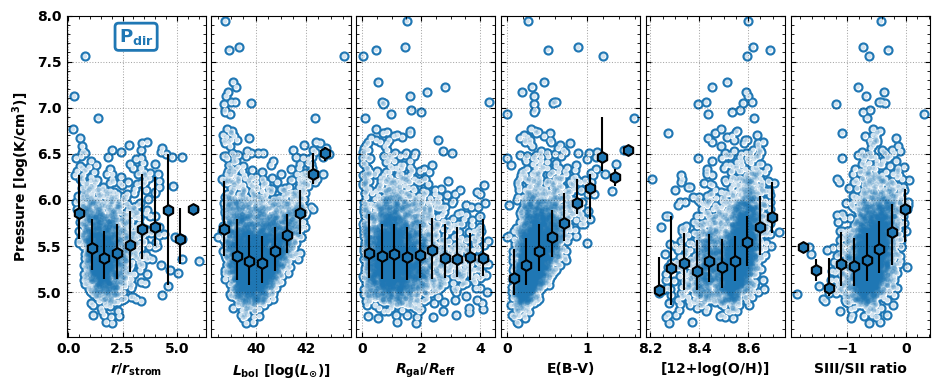

In [35]:
data_x1 = radius_norm
data_x2 = np.log10(lbol)
data_x3 = raduis_eff
data_x4 = ebv
data_x5 = met
data_x6 = ratio_siii_sii

data_y = Pdir

fig = plt.figure(figsize=(9.5, 4)) 

ax1 = fig.add_subplot(161)
ax2 = fig.add_subplot(162)
ax3 = fig.add_subplot(163)
ax4 = fig.add_subplot(164)
ax5 = fig.add_subplot(165)
ax6 = fig.add_subplot(166)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

plot_points(ax1, data_x1, data_y, 0)
plot_points(ax2, data_x2, data_y, 0)
plot_points(ax3, data_x3, data_y, 0)
plot_points(ax4, data_x4, data_y, 0)
plot_points(ax5, data_x5, data_y, 0)
plot_points(ax6, data_x6, data_y, 0)

ax1.set_xlabel('$r/r_\mathrm{strom}$')
ax2.set_xlabel('$L_\mathrm{bol}$ [log($L_\mathrm{\odot}$)]')
ax3.set_xlabel('$R_\mathrm{gal}$/$R_\mathrm{eff}$')
ax4.set_xlabel('E(B-V)')
ax5.set_xlabel('[12+log(O/H)]')
ax6.set_xlabel('SIII/SII ratio')
ax1.set_ylabel('Pressure [log(K/cm$^3$)]')

ax1.text(0.5, 0.965, 'P$_\mathrm{dir}$', size=13, va='top', ha='center', weight='heavy', 
         color='C0', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='C0', boxstyle='round,pad=0.2', linewidth=2))

for ax in axes:
    ax.set_ylim(4.51, 8)
    ax.grid(True, alpha=0.35, ls=':', color='black')

for ax in axes[1:]:
    ax.set_yticklabels([])

fig.tight_layout(w_pad=-0.8)
fig.savefig('figs/pressure_scatter_all_PDIR.pdf', bbox_inches='tight', dpi=300)

In [38]:
xlims = []
ylims = []
for ax in axes:
    xlims.append(ax.get_xlim())
    ylims.append(ax.get_ylim())

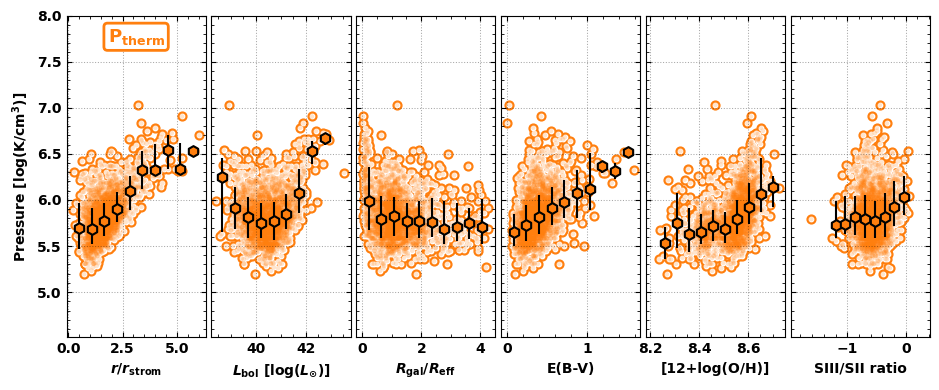

In [39]:
data_x1 = radius_norm
data_x2 = np.log10(lbol)
data_x3 = raduis_eff
data_x4 = ebv
data_x5 = met
data_x6 = ratio_siii_sii

data_y = Ptherm

fig = plt.figure(figsize=(9.5, 4)) 

ax1 = fig.add_subplot(161)
ax2 = fig.add_subplot(162)
ax3 = fig.add_subplot(163)
ax4 = fig.add_subplot(164)
ax5 = fig.add_subplot(165)
ax6 = fig.add_subplot(166)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

plot_points(ax1, data_x1, data_y, 1)
plot_points(ax2, data_x2, data_y, 1)
plot_points(ax3, data_x3, data_y, 1)
plot_points(ax4, data_x4, data_y, 1)
plot_points(ax5, data_x5, data_y, 1)
plot_points(ax6, data_x6, data_y, 1)

ax1.set_xlabel('$r/r_\mathrm{strom}$')
ax2.set_xlabel('$L_\mathrm{bol}$ [log($L_\mathrm{\odot}$)]')
ax3.set_xlabel('$R_\mathrm{gal}$/$R_\mathrm{eff}$')
ax4.set_xlabel('E(B-V)')
ax5.set_xlabel('[12+log(O/H)]')
ax6.set_xlabel('SIII/SII ratio')
ax1.set_ylabel('Pressure [log(K/cm$^3$)]')

ax1.text(0.5, 0.965, 'P$_\mathrm{therm}$', size=13, va='top', ha='center', weight='heavy', 
         color='C1', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='C1', boxstyle='round,pad=0.2', linewidth=2))

for i, ax in enumerate(axes):
    ax.set_ylim(4.51, 8)
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])

    ax.grid(True, alpha=0.35, ls=':', color='black')

for ax in axes[1:]:
    ax.set_yticklabels([])

fig.tight_layout(w_pad=-0.8)
fig.savefig('figs/pressure_scatter_all_PTHERM.pdf', bbox_inches='tight', dpi=300)

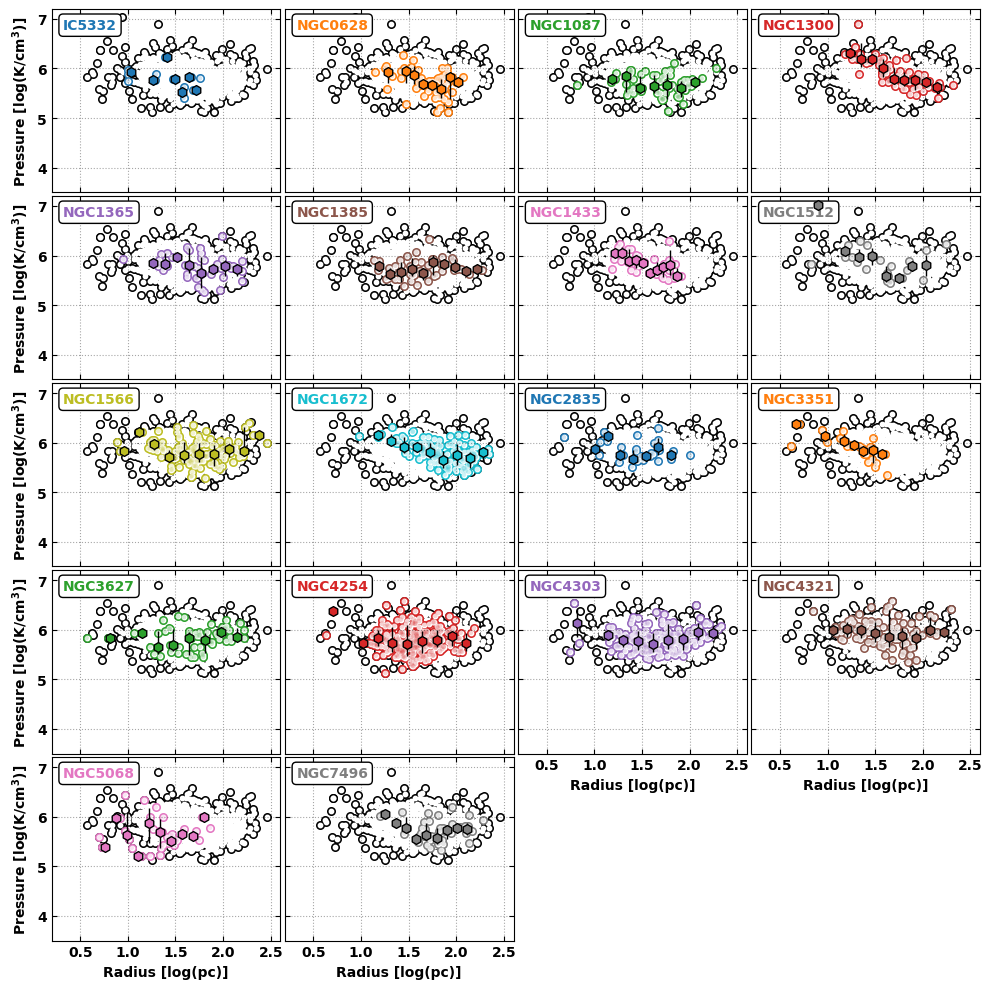

In [5]:
data_x = radius_circ_pc
data_y = Ptherm

fig = plt.figure(figsize=(10, 10)) 
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=30, c='black', rasterized=True, zorder=0)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True, zorder=0) 

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=30, c='C%i' %i, rasterized=True)
    ax.scatter(data_x_, data_y_, s=10, c='white', rasterized=True)
    ax.scatter(data_x_, data_y_, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.set_xlim(0.2, 2.6)
    ax.set_ylim(3.5, 7.2)
    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Pressure [log(K/cm$^3$)]')
    else:
        ax.set_yticklabels([])
        

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_prad_ptherm_gal.pdf', dpi=200, bbox_inches='tight')

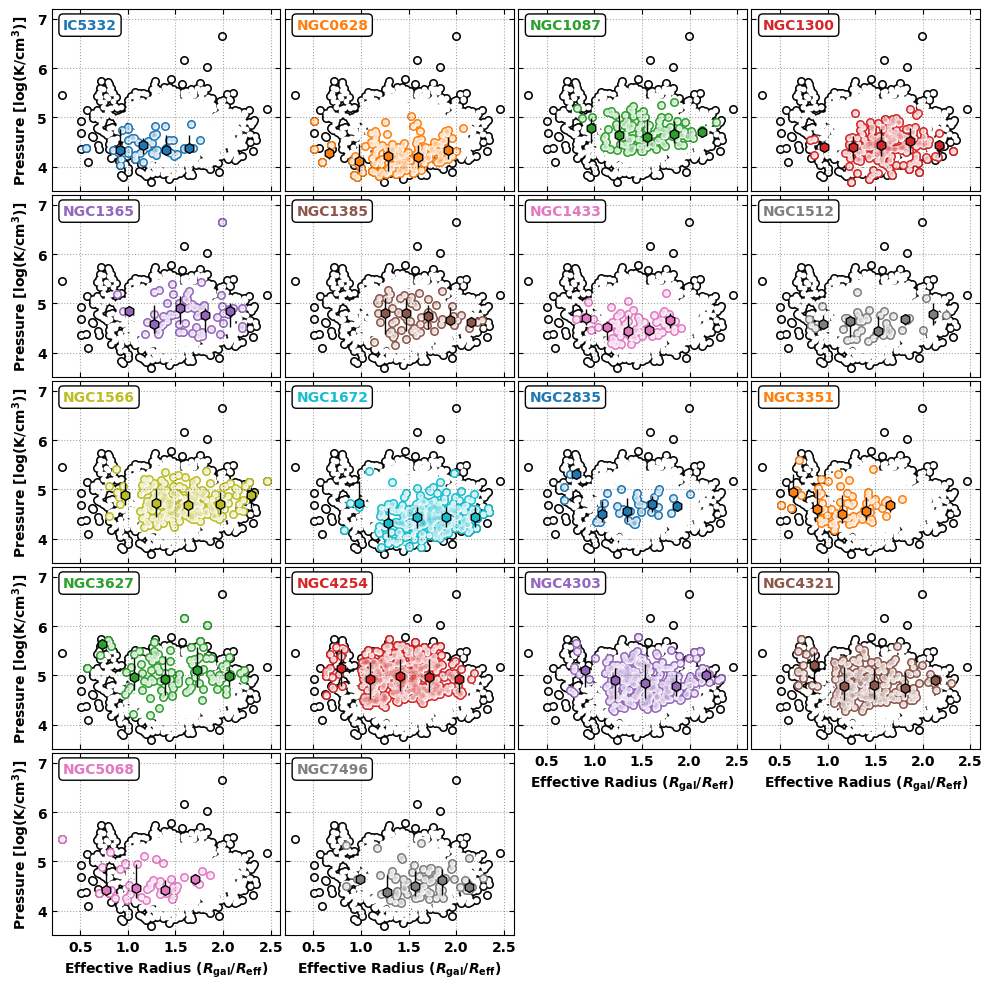

In [6]:
data_x = radius_circ_pc
data_y = Pdir_circ

fig = plt.figure(figsize=(10, 10)) 
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=30, c='black', rasterized=True, zorder=0)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True, zorder=0) 

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=30, c='C%i' %i, rasterized=True)
    ax.scatter(data_x_, data_y_, s=10, c='white', rasterized=True)
    ax.scatter(data_x_, data_y_, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=5)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.set_xlim(0.2, 2.6)
    ax.set_ylim(3.5, 7.2)
    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Effective Radius ($R_\mathrm{gal}/R_\mathrm{eff}$)')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Pressure [log(K/cm$^3$)]')
    else:
        ax.set_yticklabels([])
        

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_prgal_pdir_gal.pdf', dpi=200, bbox_inches='tight')

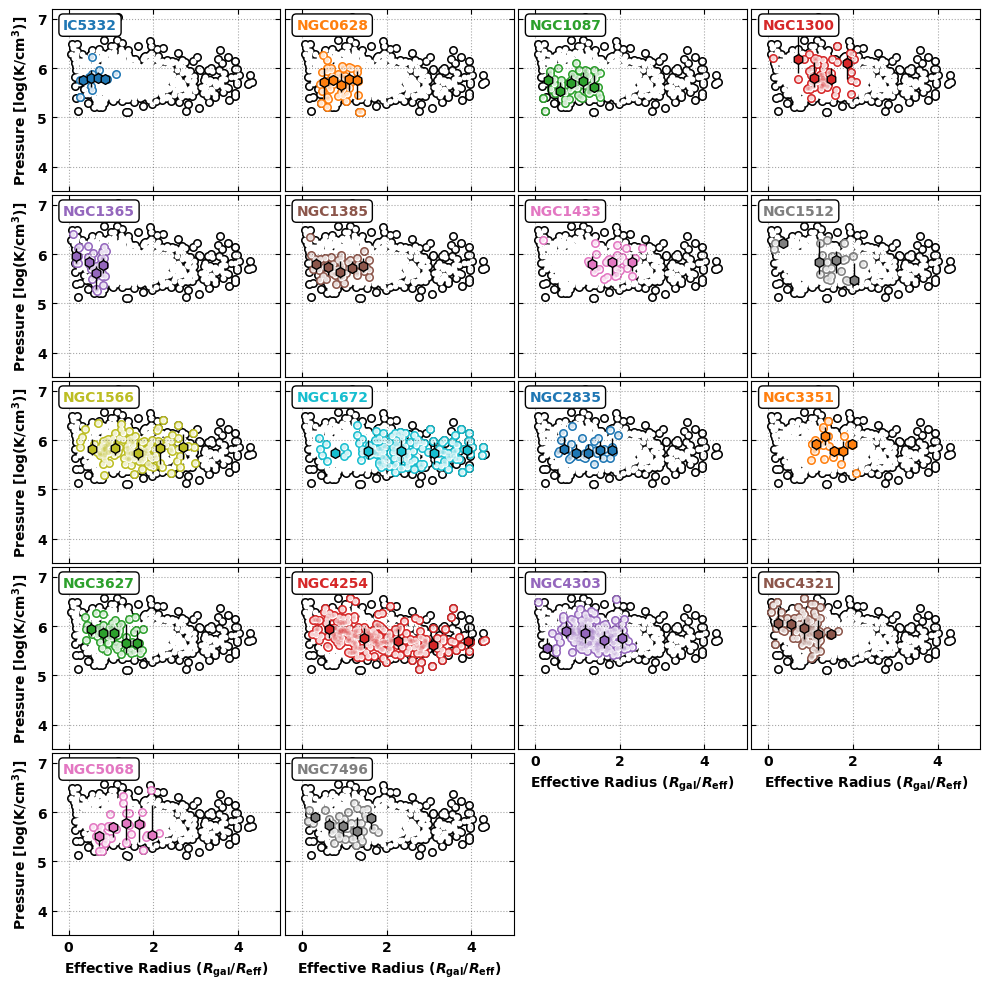

In [7]:
data_x = raduis_eff
data_y = Ptherm

fig = plt.figure(figsize=(10, 10)) 
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=30, c='black', rasterized=True, zorder=0)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True, zorder=0) 

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=30, c='C%i' %i, rasterized=True)
    ax.scatter(data_x_, data_y_, s=10, c='white', rasterized=True)
    ax.scatter(data_x_, data_y_, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=5)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.set_xlim(-0.4, 5)
    ax.set_ylim(3.5, 7.2)
    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Effective Radius ($R_\mathrm{gal}/R_\mathrm{eff}$)')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Pressure [log(K/cm$^3$)]')
    else:
        ax.set_yticklabels([])
        
fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_prgal_ptherm_gal.pdf', dpi=200, bbox_inches='tight')

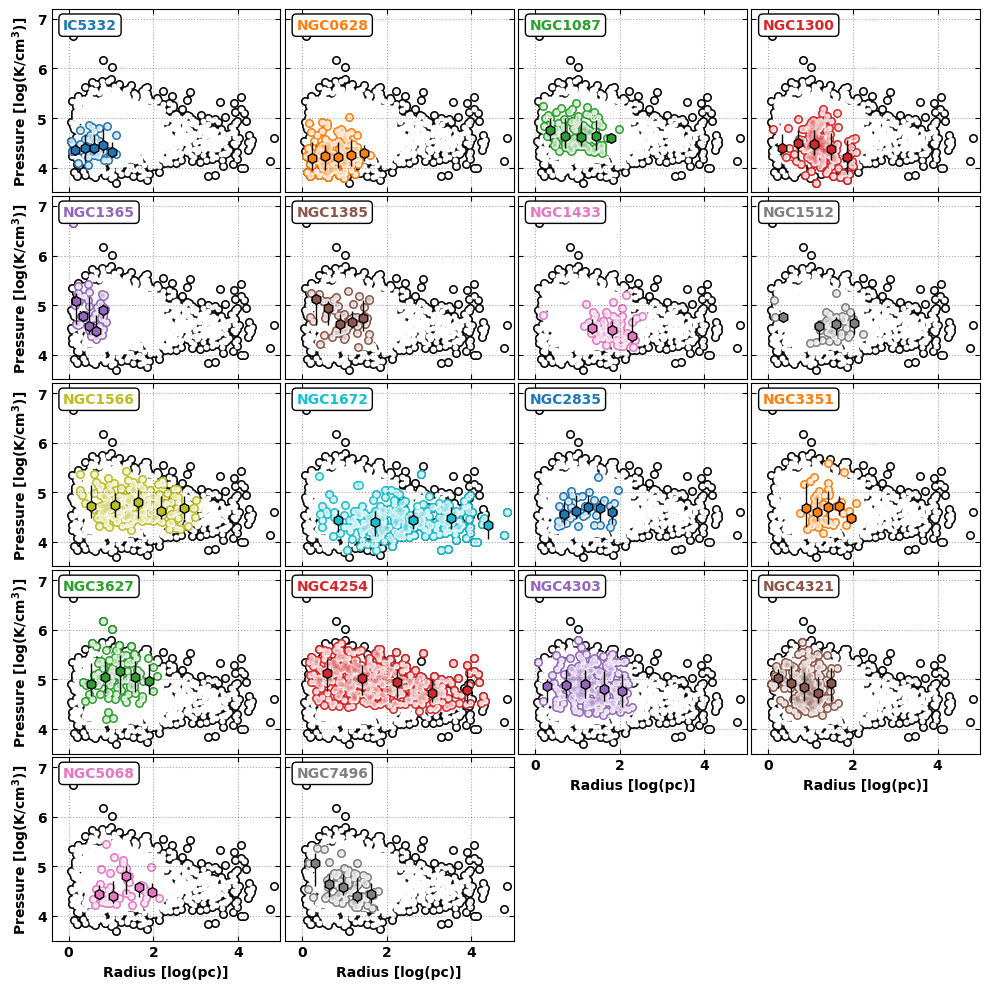

In [8]:
data_x = raduis_eff
data_y = Pdir_circ

fig = plt.figure(figsize=(10, 10)) 
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=30, c='black', rasterized=True, zorder=0)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True, zorder=0) 

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=30, c='C%i' %i, rasterized=True)
    ax.scatter(data_x_, data_y_, s=10, c='white', rasterized=True)
    ax.scatter(data_x_, data_y_, s=12, alpha=0.2, rasterized=True, fc='C%i'%i, ec='none')

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=5)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.set_xlim(-0.4, 5)
    ax.set_ylim(3.5, 7.2)
    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Pressure [log(K/cm$^3$)]')
    else:
        ax.set_yticklabels([])
        

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_prgal_pdir_gal.pdf', dpi=200, bbox_inches='tight')